# tSNE

In [1]:
!pip install kaggle Pillow imageio matplotlib pandas torchsummary
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces

import shutil
shutil.unpack_archive('140k-real-and-fake-faces.zip')

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other


In [2]:
import os
import numpy as np
from tqdm import tqdm
import datetime
from copy import deepcopy
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
torch.manual_seed(69)

In [3]:
# Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 256
NUM_WORKERS = 2
CHECKPOINT_PRO_GEN = "pro_generator_128_2.pth"
CHECKPOINT_PRO_DISC = "pro_disc_128_3.pth"
PRO_LR = 5.5e-4
FACTORS = [1, 1/2, 1/4, 1/8, 1/16, 1/32]
IN_CHANNELS = 512

In [4]:
def load_checkpoint(checkpoint_file, model, optimizer=None, lr=None):
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])

        # If we don't do this then it will just have learning rate of old checkpoint
        # and it will lead to many hours of debugging \:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    print("=> Loaded checkpoint")

## Data

In [5]:
REAL_FOLDER = "/content/real_vs_fake/real-vs-fake/test/real"

In [6]:
real_paths = [os.path.join(root, file) for root, _, files in os.walk(REAL_FOLDER) for file in files][:BATCH_SIZE]
print("real count:",len(real_paths))

real count: 256


In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        """
        Args:
            image_paths (list): List of image file paths.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Open image and convert to RGB

        if self.transform:
            image = self.transform(image)

        return image

In [8]:
transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.ToTensor(),
  transforms.Normalize(
      [0.5 for _ in range(3)],
      [0.5 for _ in range(3)]),
])

real_dataset = ImageDataset(real_paths, transform=transform)

real_dataloader = DataLoader(real_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

## Models

In [9]:
class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        # Converts n channel image to rgb channel
        self.initial_vec_to_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )

        self.prog_blocks, self.vec_to_rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_vec_to_rgb]),
        )

        for i in range(
            len(FACTORS) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * FACTORS[i])
            conv_out_c = int(in_channels * FACTORS[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.vec_to_rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * generated + (1 - alpha) * upscaled

    def forward(self, x, alpha=0.5, steps=5):
        out = self.initial(x) # 1x1 to 4x4

        if steps == 0:
            return self.initial_vec_to_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different vec_to_rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.vec_to_rgb_layers[steps - 1](upscaled)
        final_out = self.vec_to_rgb_layers[steps](out)
        return torch.tanh(self.fade_in(alpha, final_upscaled, final_out))

pro_gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
opt_pro_gen = optim.Adam(
    pro_gen.parameters(), lr=1e-3, betas=(0.0, 0.99)
)

load_checkpoint(CHECKPOINT_PRO_GEN, pro_gen)

pro_gen.eval()

progen_fake_z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(DEVICE)

=> Loaded checkpoint


In [11]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_to_vec_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb_to_vec layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(FACTORS) - 1, 0, -1):
            conv_in = int(in_channels * FACTORS[i])
            conv_out = int(in_channels * FACTORS[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_to_vec_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb_to_vec" this is just the RGBto_vec layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb_to_vec
        self.initial_rgb_to_vec = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_to_vec_layers.append(self.initial_rgb_to_vec)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha=0.5, steps=5):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb_to_vec as initial step, this will depend on
        # the image size (each will have it's on rgb_to_vec layer)
        out = self.leaky(self.rgb_to_vec_layers[cur_step](x))

        if steps != 0:# i.e, image is anything other than 4x4
            # because prog_blocks might change the channels, for down scale we use rgb_to_vec_layer
            # from previous/smaller size which in our case correlates to +1 in the indexing
            downscaled = self.leaky(self.rgb_to_vec_layers[cur_step + 1](self.avg_pool(x)))
            out = self.avg_pool(self.prog_blocks[cur_step](out))

            # the fade_in is done first between the downscaled and the input
            # this is opposite from the generator
            out = self.fade_in(alpha, downscaled, out)

            for step in range(cur_step + 1, len(self.prog_blocks)):
                out = self.prog_blocks[step](out)
                out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

pro_disc = Discriminator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
opt_pro_disc = optim.Adam(
    pro_disc.parameters(), lr=1e-3, betas=(0.0, 0.99)
)

load_checkpoint(CHECKPOINT_PRO_DISC, pro_disc, opt_pro_disc, PRO_LR,)

pro_disc.final_block.pop(4)
pro_disc.final_block.pop(3)
pro_disc.final_block.add_module('Flatten', nn.Flatten())

for param in pro_disc.parameters():
    param.requires_grad = False

pro_disc.eval()

=> Loaded checkpoint


Discriminator(
  (prog_blocks): ModuleList(
    (0): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (1): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (2): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

## Vector representations

In [12]:
real_images = next(iter(real_dataloader)).to(DEVICE)
real_vectors = pro_disc(real_images)
del real_images
torch.cuda.empty_cache()

In [13]:
progan_fake_images = pro_gen(progen_fake_z)
progan_fake_vectors = pro_disc(progan_fake_images)
del progan_fake_images
torch.cuda.empty_cache()

## Visualization

In [14]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

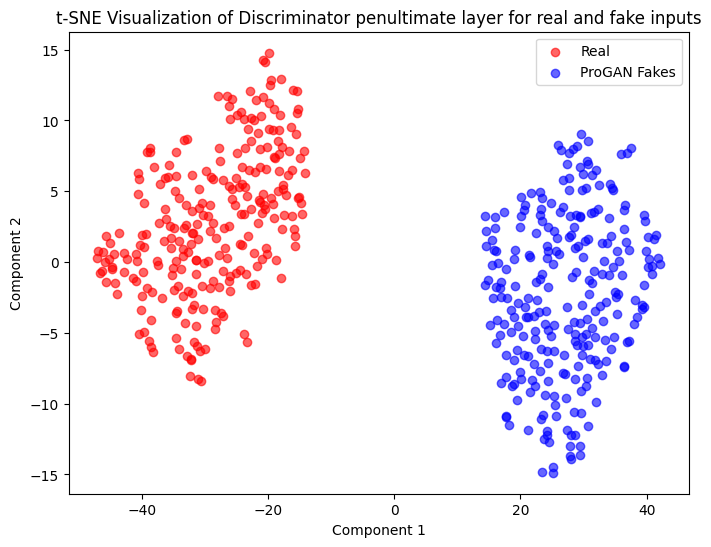

In [15]:
data = torch.cat([real_vectors.cpu().detach(), progan_fake_vectors.cpu().detach(),], dim=0).numpy()
labels = np.array([0] * len(real_vectors) +  [1] * len(progan_fake_vectors))  # Assign category labels

tsne = TSNE(n_components=2, perplexity=30, random_state=69)
data_2d = tsne.fit_transform(data)

plt.figure(figsize=(8, 6))
for category, color, label_name in zip([0, 1], ['red', 'blue'], ['Real', 'ProGAN Fakes']):
    indices = labels == category
    plt.scatter(data_2d[indices, 0], data_2d[indices, 1], c=color, label=label_name, alpha=0.6)

plt.title("t-SNE Visualization of Discriminator penultimate layer for real and fake inputs")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()